# EV trip resilience 🪫🚙🔋

Exploring resilient EV trip planning. How can we plan to efficiently accommodate faulty chargers?

## Setup

We use these modules and classes. Some fields and units are optional, which will need attention when real data is used.

In [1]:
import bisect
import itertools
import matplotlib.pyplot as plt
import numpy as np
from ortools.sat.python import cp_model

from shapely import distance, Point
from shapely.plotting import plot_line, plot_points, plot_polygon
from shapely.geometry import LineString
from shapely.ops import nearest_points

In [2]:
class EVehicle:
    def __init__(self, ev_range=12, capacity=5, mass=2500):
        self.ev_range = ev_range
        self.capacity = capacity
        self.mass = mass
        
    def set_soc(self, soc):
        self.soc = soc

In [3]:
class Charger():
    def __init__(self, location=Point(0, 7), power=50, amenity=50):
        self.location = location
        self.power = power
        self.amenity = amenity

class RoutePoint():
    def __init__(self, location):
        self.location = location

In [4]:
class Route:
    def __init__(self, locations=[Point(0, 0), Point(0, 10)]):
        self.nodes = [RoutePoint(l) for l in locations]
        self.calculate()
            
    def locations(self):
        return [p.location for p in self.nodes]

    def calculate(self):
        self.path = LineString(self.locations())
        # Todo - better with project points & diff?
        self.legs = [int(round(distance(a, b))) for a, b in zip(self.locations()[:-1], self.locations()[1:])]
        self.cums = np.cumsum(self.legs, dtype=int)
    
    def add_charger(self, c):
        # create a new point on the route when we add a charger
        projection_dist = self.path.project(c.location)
        leg = 1 + bisect.bisect_left(self.cums, projection_dist)
        self.nodes.insert(leg, c)
        self.calculate()
    
    def add_chargers(self, cs):
        for c in cs:
            self.add_charger(c)
            
    def chargers(self):
        return [n for n in self.nodes if isinstance(n, Charger)]
    
    def can_charge(self, point_i):
        return isinstance(self.nodes[point_i], Charger)

## Simulate & visualise

These methods simulate a trip plan and visualise the resultant trip. Plenty of scope to improve, not least eliminating magic numbers.

In [5]:
def simulate(ev, route, charge):
    arr_flowers = []
    dep_flowers = []
    total_charge_time = 0
    i = 0
    j = 0
    dep_flowers.append((route.locations()[i], ev.soc * ev.ev_range))
    while(i < len(r.nodes) - 1 and ev.soc * ev.ev_range >= route.legs[i]):
        soc_consumed = route.legs[i] / ev.ev_range
        soc_arrival = ev.soc - soc_consumed
        arr_flowers.append((route.locations()[i + 1], soc_arrival * ev.ev_range))
        soc_departure = soc_arrival
        if route.can_charge(i + 1):
            if charge[j] > 0:
                soc_departure = soc_arrival + (charge[j] / 100.0)
                charge_amount = (soc_departure - soc_arrival) * ev.capacity
                charger_power = route.nodes[i + 1].power
                charge_time = 100 * charge_amount / charger_power
                total_charge_time = total_charge_time + charge_time + 0.1
                dep_flowers.append((route.locations()[i + 1], soc_departure * ev.ev_range))
            j = j + 1
        ev.set_soc(soc_departure)
        i = i + 1
    unreachable = route.locations()[i + 1:]
    return arr_flowers, dep_flowers, unreachable, total_charge_time

In [6]:
def visualise(flowers, ev, route, charge, title='TRIP PLAN'):
    fig = plt.figure(1, figsize=(4.5,6))
    plt.xlim(-6, 12)
    plt.ylim(-9, 15)
    plt.axis('off')
    ax = plt.gca()
    fig.patch.set_facecolor('white')
    fig.patch.set_edgecolor('black')
    plt.text(6, 0, 'depart', verticalalignment='center')
    if len(flowers[2]) == 0:
        plt.text(6, 10, f'arrive {int(ev.soc * 100)}%', verticalalignment='center')
    else:
        plt.text(6, 10, f'unreachable', verticalalignment='center')
    for i, c in enumerate(charge):
        y = route.chargers()[i].location.y
        if c > 0:
            plt.text(6, y, f'charge {charge[i]:.0f}%', verticalalignment='center', color='xkcd:orange')
            plt.plot([1, 5], [y, y], color='darkorange', linestyle=':') 
        else:
            plt.text(6, route.chargers()[i].location.y, f'skip', verticalalignment='center', color='teal')
    plot_line(r.path, ax=ax, color='teal')
    for f in flowers[0]:
        if (f[1] > 0.01):
            plot_polygon(f[0].buffer(f[1]), ax=ax, add_points=False, color='teal')
    for f in flowers[1]:
        if (f[1] > 0.01):
            plot_polygon(f[0].buffer(f[1]), ax=ax, add_points=False, color='darkorange')
    plt.title(title + f' (time {flowers[3]:0.1f})')
    plt.show()

## Test scenario

This scenario includes a vehicle and a route with chargers

In [7]:
ev = EVehicle(ev_range=5)
r = Route(locations=[Point(0, 0), Point(0, 10)])
c1 = Charger(location=Point(0, 3), power=50)
c2 = Charger(location=Point(0, 4), power=100)
c3 = Charger(location=Point(0, 7), power=250)
c4 = Charger(location=Point(0, 8), power=250)
cs = [c1, c2, c3, c4]
r.add_chargers(cs)

An initial SOC and charge pattern define a trip plan

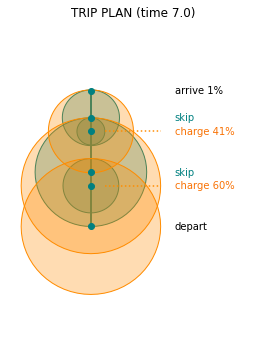

In [8]:
ev.set_soc(1)
charge = [60, 0, 41, 0]
flowers = simulate(ev, r, charge)
visualise(flowers, ev, r, charge)

## Optimisation

### Model definition, base trip constraints, and objective

In [9]:
def define_variables(model, chargers):
    indexes = range(len(chargers))
    arrivals = [model.NewIntVar(0, 100, f"a{i}") for i in indexes]
    fills = [model.NewIntVar(0, 100, f"f{i}") for i in indexes]                    
    stops = [model.NewBoolVar(f"s{i}") for i in indexes]
    return arrivals, fills, stops

Some factors will need attention to units/scaling in future

In [10]:
def define_base_constraints(model, arrivals, fills, stops, ev, route, origin_soc=100):
    nc = len(fills)
    # fill > 0 means stop
    for f, s in zip(fills, stops):
        model.Add(f > 0).OnlyEnforceIf(s)
        model.Add(f == 0).OnlyEnforceIf(s.Not())
    
    # can't have > 100 soc
    for a, f in zip(arrivals, fills):
        model.Add(a + f <= 100)

    # arrival soc must match previous departure and consumption between
    model.Add(arrivals[0] * ev.ev_range == (ev.ev_range - route.legs[0]) * 100)
    for i in range(1, nc):
        model.Add(arrivals[i] * ev.ev_range == (arrivals[i-1] + fills[i-1]) * ev.ev_range - route.legs[i] * 100)
    model.Add((arrivals[nc-1] + fills[nc-1] - 1) * ev.ev_range >= route.legs[nc] * 100)

In [11]:
model = cp_model.CpModel()

In [12]:
arrivals, fills, stops = define_variables(model, cs)

In [13]:
define_base_constraints(model, arrivals, fills, stops, ev, r)

In [14]:
# objective: minimise filling time
model.Minimize(sum([f * int(1000 * ev.capacity / cs[i].power) for i, f in enumerate(fills)]) \
             + sum(stops) * 100)

### Additional resilience constraints

Enable or disable constraints below. These will also need attention to units/scaling.

In [15]:
# constraint: arrive destination with more than 20% soc
dest_soc = 0.2
model.Add((arrivals[len(cs)-1] + fills[len(cs)-1]) * ev.ev_range >= (int(ev.ev_range * dest_soc) + r.legs[len(cs)]) * 100)

In [16]:
# constraint: arrive each charger with more than 20% soc
#for a in arrivals:
#    model.Add(a >= 20)

In [17]:
# constraint: leave charger with enough to get to next + 1
for i, (a, f) in enumerate(zip(arrivals[:-1], fills[:-1])):
    model.Add((a + f) * ev.ev_range >= (r.legs[i] + r.legs[i+1]) * 100)

In [18]:
# constraint: leave charger with enough to return to previous
#for i, (a, f) in enumerate(zip(arrivals, fills)):
#    model.Add((a + f) * ev.ev_range >= r.legs[i] * 100)

### Solve and visualise optimal plan

In [19]:
solver = cp_model.CpSolver()
status = solver.solve(model)

In [20]:
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print(f"Solution - {status}:")
    print("Objective value =", solver.objective_value / 1000)    
    print("arrivals =", [solver.value(a) for a in arrivals])
    print("fills =", [solver.value(f) for f in fills])
    print("stops =", [solver.value(s) for s in stops])
else:
    print("The problem does not have a solution.")

Solution - 4:
Objective value = 6.5
arrivals = [40, 60, 20, 60]
fills = [40, 20, 60, 0]
stops = [1, 1, 1, 0]


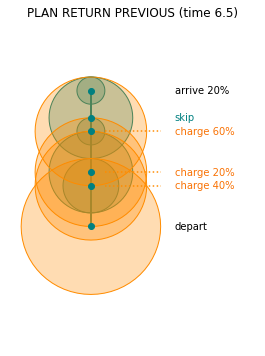

In [21]:
ev.set_soc(1)
opt_charge = [solver.value(f) for f in fills]
flowers = simulate(ev, r, opt_charge)
visualise(flowers, ev, r, opt_charge, title='PLAN RETURN PREVIOUS')